In [15]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
mpl.rcParams['figure.dpi'] = 175
h = 6.6260755e-27 # Planck's constant [erg] [s]
q = 4.803e-10 # electron charge

def power_law(gamma, power, A):
    return A * gamma ** (power)

def eV_e(gamma):
    return (gamma*9.109e-31*2.998e8**2) / 1.602e-19

def gamma_e(eV):
    return eV / 511000

def eV_p(freq):
    return 4.1357e-13*freq

def make_odd(num):
    if (num % 2 == 0):
        return num + 1
    else:
        return num

In [12]:
def power_law(gamma, power, A):
    return A * gamma ** (power)

def find_powerlaw_transition(x, y, window_length=15, poly_order=2):
    """
    Find the transition point between two power laws in log-log space.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (e.g., gamma values)
    y : array-like
        y-coordinates (e.g., particle distribution)
    window_length : int, optional
        Window length for Savitzky-Golay filter (must be odd)
    poly_order : int, optional
        Polynomial order for the smoothing filter
        
    Returns:
    --------
    transition_point : float
        x-value where the power law transition occurs
    slopes : tuple
        (slope before transition, slope after transition)
    """
    # Convert to log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    
    # Compute numerical derivative (gradient)
    # First smooth the data to reduce noise
    smooth_log_y = savgol_filter(log_y, window_length, poly_order)
    
    # Calculate gradient using central differences
    gradient = np.gradient(smooth_log_y, log_x)
    
    # Smooth the gradient
    smooth_gradient = savgol_filter(gradient, window_length, poly_order)
    
    # Find where gradient changes most rapidly (second derivative peaks)
    second_derivative = np.abs(np.gradient(smooth_gradient, log_x))
    
    # Find the peak in second derivative
    # Exclude edges to avoid boundary effects
    margin = window_length
    peak_idx = margin + np.argmax(second_derivative[margin:-margin])
    
    # Fit power laws to both regions to get precise slopes
    def power_law(x, alpha, c):
        return c + alpha * x
    
    # Split data at the identified transition point
    split_idx = peak_idx
    
    # Fit before transition
    popt1, _ = curve_fit(power_law, log_x[:split_idx], log_y[:split_idx])
    # Fit after transition
    popt2, _ = curve_fit(power_law, log_x[split_idx:], log_y[split_idx:])
    
    return peak_idx, (popt1[0], popt2[0])

def fit_4th_order(x, y, zorder=0):
    # Fit a 4th order polynomial to the data
    coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
    poly = np.poly1d(coefficients)
    print(np.poly1d(coefficients))
    # Calculate fitted values and errors
    x_fit = np.linspace(min(x), max(x), 100)
    log_y_fit = poly(np.log10(x_fit))
    y_fit = 10**log_y_fit
    # Calculate errors (simplified estimate)
    residuals = np.log10(y) - poly(np.log10(x))
    std_dev = np.std(residuals)
    error_margin = std_dev
    y_fit_lower = 10**(log_y_fit - error_margin)
    y_fit_upper = 10**(log_y_fit + error_margin)
    # Plot the fit and error bands
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.5, label="4th order polynomial fit", zorder=zorder)


# IMPLICIT STEP

In [30]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
def create_animated_plot(csv_path, column_prefix='n_e t='):
    """
    Create an animated plot from a CSV file with log-scaled axes, showing both
    theoretical predictions and measured data
    """
    # Setup paths and read data
    run_path = ""
    for folder in csv_path.split(r"\ "[0])[:-1]:
        run_path += folder + r"\ "[0]
    run_path += "runs" + r"\run_" + csv_path.split(r"\ "[0])[-1]
    df = pd.read_csv(csv_path)
    run_df = pd.read_csv(run_path)
    
    # Find time columns
    time_columns = [col for col in df.columns if column_prefix in col]
    df_time_steps = df[time_columns]
    
    # Create figure and set up axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set labels
    plt.xlabel('$\gamma$')
    plt.ylabel('$n_e$')
    
    # Create vertical lines once
    gamma_c = 1/(run_df["S"][0] * run_df["tau_esc"][0] * (1 - run_df["inject_p"][0]))
    plt.vlines([run_df["inject_min"][0],gamma_c], 1e-32,1e-14,["grey","darkgrey"],["dashed","dashed"])
    
    # Prepare theoretical curve data
    gammas = np.logspace(1, 8, 1000)  # More points for smoother animation
    inject_index = (np.abs(gammas-run_df["inject_min"][0])).argmin()
    
    # extract relevant values
    gammas[inject_index:]
    inject_p = run_df["inject_p"][0]
    S = run_df["S"][0]
    C = run_df["Q_e0"][0] * run_df["norm"][0]
    tau = run_df["tau_esc"][0]
    lw = 5
    # Create line objects for both theoretical curves and data
    theory_line1, = ax.plot([], [], 
                           c="lightgrey", 
                           alpha=0.7, 
                           ls="-",
                           lw=lw,
                           label=f"$\propto\gamma^{{{-inject_p-1}}}$")
    
    theory_line2, = ax.plot([], [], 
                           c="dimgrey",
                           alpha=0.6, 
                           ls="-",
                           lw=lw,
                           label=f"$\propto\gamma^{{{-inject_p}}}$")
    
    data_line, = ax.plot([], [], 
                        ls='-', 
                        label=f'B = {run_df["B"][0]}')
    
    def init():
        """Initialize animation"""
        theory_line1.set_data([], [])
        theory_line2.set_data([], [])
        data_line.set_data([], [])
        return theory_line1, theory_line2, data_line
    
    def update(frame):
        """Update animation frame"""
        # Get current time step data
        current_data = df_time_steps.iloc[:-1, frame]
        epsilon = 1e-300

        # Update measured data
        x_data = np.array(df["gamma"][:-1])
        y_data = np.array(np.abs(current_data) + epsilon)
        data_line.set_data(x_data, y_data)

        inject_index = (np.abs(x_data-run_df["inject_min"][0])).argmin()
        x_data=x_data[inject_index:]
        y_data=y_data[inject_index:]
        
        # extract time value
        time_value = float(time_columns[frame].split('=')[1])

        # plot theoretical curves
        theory1_y = np.array(power_law(gammas, -inject_p-1, C / (S*(1-inject_p))))
        theory2_y = np.array(power_law(gammas, -inject_p, C * tau))

        if (time_value < 1e7):
            turnover_index, _ = find_powerlaw_transition(x_data, y_data, window_length=make_odd(int(len(x_data)*0.25)))
            turnover_index_theory = (np.abs(gammas-x_data[turnover_index])).argmin()
            # normalize the less steep power law to the gamma_c value
            theory2_y /= theory2_y[turnover_index_theory]
            theory2_y *= y_data[turnover_index]
            # normalize the less steep power law to the gamma_c value
            theory2_y /= theory2_y[turnover_index_theory]
            theory2_y *= y_data[turnover_index]
        else:
            turnover_index = (np.abs(x_data-gamma_c)).argmin()
            turnover_index_theory = (np.abs(gammas-gamma_c)).argmin()
        
        theory_line1.set_data(gammas, theory1_y)
        theory_line2.set_data(gammas, theory2_y)
        
        # Set axis limits
        ax.set_xlim(1e1, 1e8)
        ax.set_ylim(1e-28, 1e-14)
        
        plt.title(f'Implicit Solver Relaxation - Time: {time_value:.2e}')
        
        return theory_line1, theory_line2, data_line
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(time_columns),
        init_func=init,
        interval=33.33,  # ~30 fps
        blit=True
    )
    
    plt.legend()
    return anim
# Function to save the animation
def save_animation(csv_path, output_path='animated_log_plot.gif', column_prefix='n_e t='):
    """
    Save the animated plot as a GIF
    
    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file
    output_path : str, optional
        Path to save the output GIF (default: 'animated_log_plot.gif')
    column_prefix : str, optional
        Prefix of the columns representing time steps
    """
    # Create and save the animation
    plt.ioff()  # Turn off interactive mode
    anim = create_animated_plot(csv_path, column_prefix)
    
    # Save the animation
    anim.save(output_path, writer='pillow')
    print(f"Animation saved to {output_path}")
    
    # Close the plot to free up memory
    plt.close()



In [31]:
csv_path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\simulation_data.csv"
save_animation(csv_path)

Animation saved to animated_log_plot.gif


In [162]:
plt.close()

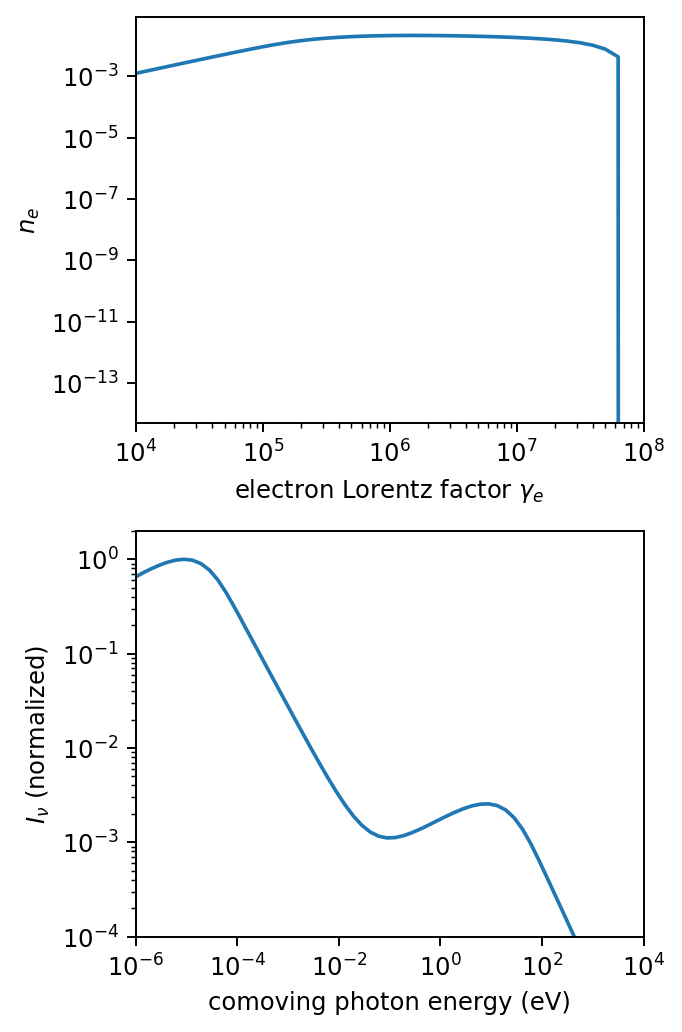

In [159]:
# Example code

sim_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\simulation_data.csv")

fig, ax = plt.subplots(2, 1, figsize = (4, 6))

# plot the electron population
ax[0].loglog(sim_data["gamma"], sim_data["n_e final"]*(sim_data["gamma"]**3.2))
ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(1e4, 1e8)
#ax[0].set_ylim(1e-32, 1e-12)

# plot the resulting photon population
ax[1].loglog(eV_p(sim_data["photon_freq"][1:-1]), sim_data["photon_n"][1:-1])
ax[1].set_xlabel(r"comoving photon energy (eV)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
ax[1].set_xlim(1e-6, 1e4)
ax[1].set_ylim(1e-4, 2e0)
plt.tight_layout()

# show
plt.draw()
plt.show()

B = 0.1
B = 0.25
B = 0.5
B = 1.0
B = 1.5
B = 2.0


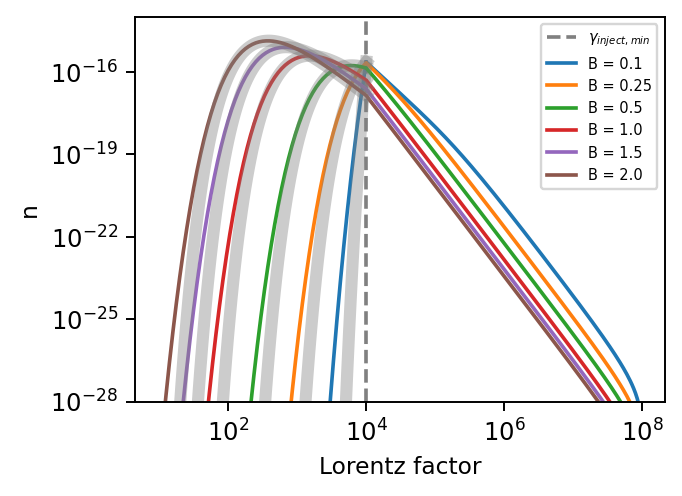

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define your cooling_LHS function with fixed tau and S
def cooling_LHS(gamma, C, tau=1, S=1):  # Example values for tau and S
    return C * np.exp(1)**(1 / (S * tau * gamma)) / gamma ** 2

def plot_with_fit(files, names, fontsize=10, x_range=[1e1, 1e5], y_range=[1e-28, 1e-14], plot_initial=False, folder="csv_data", lnn_bool=False):
    colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", 
               "tab:brown", "tab:pink","tab:grey", "tab:olive", "tab:cyan"]
    plt.figure(figsize=[4, 3])
    plt.vlines(1e4, 1e-28, 2e12, "grey", "dashed", lw=1.5, label="$\gamma_{inject,min}$")

    for file, name, colour in zip(files, names, colours[:len(files)]):
        print(name)
        run_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\{}\runs\run_{}.csv".format(folder,file[:-4]))
        sim_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\{}\{}".format(folder,file), header=None, low_memory=False)
        
        sim_data = sim_data.T
        sim_data.columns = sim_data.iloc[0]
        sim_data = sim_data[1:]
        sim_data.reset_index(drop=True, inplace=True)
        plot_y = sim_data.iloc[:, -1]
        if lnn_bool:
            plot_y = np.exp(1.)**plot_y
        plt.plot(sim_data["gamma"], plot_y, label=name, c = colour)

        # Define cooling_LHS with run_data params
        def cooling_LHS(gamma, C, tau=run_data["tau_esc"].values[0], S=run_data["S"].values[0]):
            return C * np.exp(1)**(1 / (S * tau * gamma)) / gamma ** 2

        # Example data
        sim_data = sim_data.fillna(0)

        sim_data = sim_data[sim_data.iloc[:, -1] != 0]
        gamma_data = sim_data["gamma"][sim_data["gamma"] <= run_data["inject_min"].values[0]]
        cooling_data = sim_data.iloc[:, -1][sim_data["gamma"] <= run_data["inject_min"].values[0]]

        if lnn_bool:
            cooling_data = np.exp(1.)**cooling_data
        # Fit the model to the data
        initial_guess = [1]

        popt, pcov = curve_fit(cooling_LHS, gamma_data, cooling_data, p0=initial_guess)
        
        # Optimal parameter
        C_opt = popt[0]
        
        # Generate fitted values
        cooling_fit = cooling_LHS(gamma_data, C_opt)
        
        # Plot the data and the fit
        plt.plot(gamma_data, cooling_fit, c="grey", alpha=0.4, ls="-", lw=5)
    
    if plot_initial:
        plot_y = sim_data.iloc[:, 1]
        if lnn_bool:
            plot_y = np.exp(1.)**plot_y
        plt.plot(sim_data["gamma"], plot_y, "-", c = "black", zorder=0, label="init_dist")
    
    # Add labels and legend with optional fontsize
    plt.ylabel("n", fontsize=fontsize*0.8)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Lorentz factor", fontsize=fontsize*0.8)
    plt.xlim(*x_range)
    plt.ylim(*y_range)
    plt.legend(fontsize=fontsize*0.5)
    #plt.grid(which="minor")
    plt.tight_layout()
    plt.show()

# Example usage with optional fontsize
files = ["B 100.csv", "B 250.csv", "B 500.csv", "B1000.csv", "B1500.csv", "B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plot_with_fit(files, names, fontsize=12, lnn_bool=False, x_range=[None, None])

          4           3          2
0.001626 x - 0.06817 x - 0.3657 x - 0.9815 x + 7.416


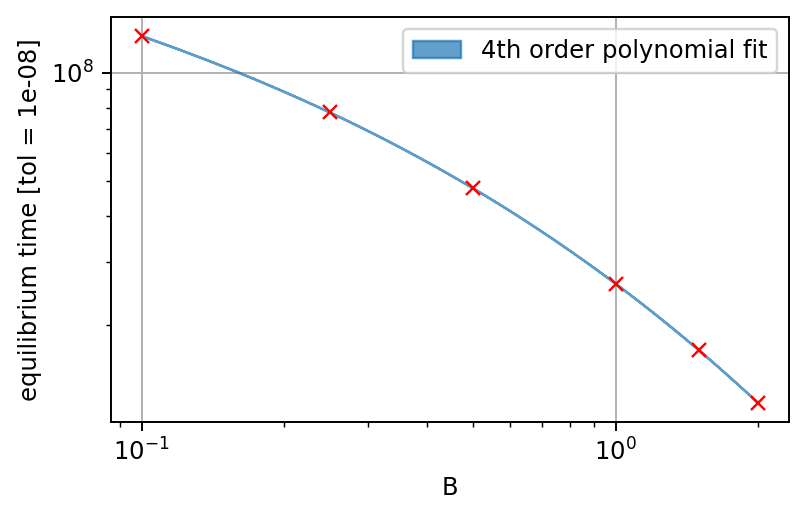

In [113]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]

# Define your model function
def model(x, a, b):
    return a * x**b

x=[]
y=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    x.append(sim_data["B"][0])
    y.append(sim_data["final_time"][0])
x=np.array(x)
y=np.array(y)
y = y
plt.plot(x, y, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(x), max(x), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(y) - poly(np.log10(x))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [tol = {sim_data['end_tol'][0]}]")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("B")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.99)

          4           3          2
0.004314 x - 0.05191 x + 0.1728 x + 0.5146 x + 6.202


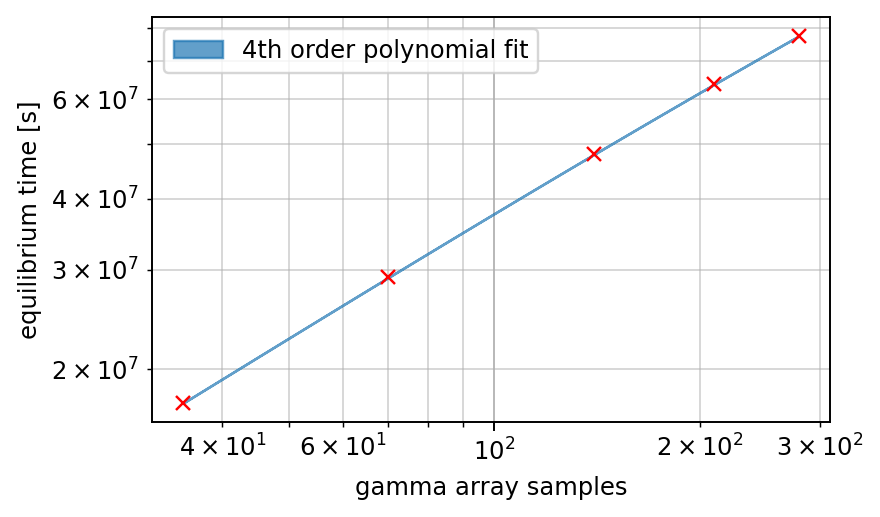

In [114]:
files = ["samples_pd5.csv","samples_pd10.csv","samples_pd20.csv","samples_pd30.csv","samples_pd40.csv"]
names = ["spd = 5", "spd = 10", "spd = 20", "spd = 30", "spd = 40"]

# Define your model function
def model(x, a, b):
    return a * x**b

x=[]
y=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    x.append(sim_data["array_len"][0])
    y.append(sim_data["final_time"][0])
x=np.array(x)
y=np.array(y)
y = y
plt.plot(x, y, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(x), max(x), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(y) - poly(np.log10(x))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [s]")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("gamma array samples")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.9)
plt.grid(which="minor", alpha=0.5)

           4           3          2
-0.002829 x + 0.09736 x - 0.9045 x + 3.313 x + 2.698


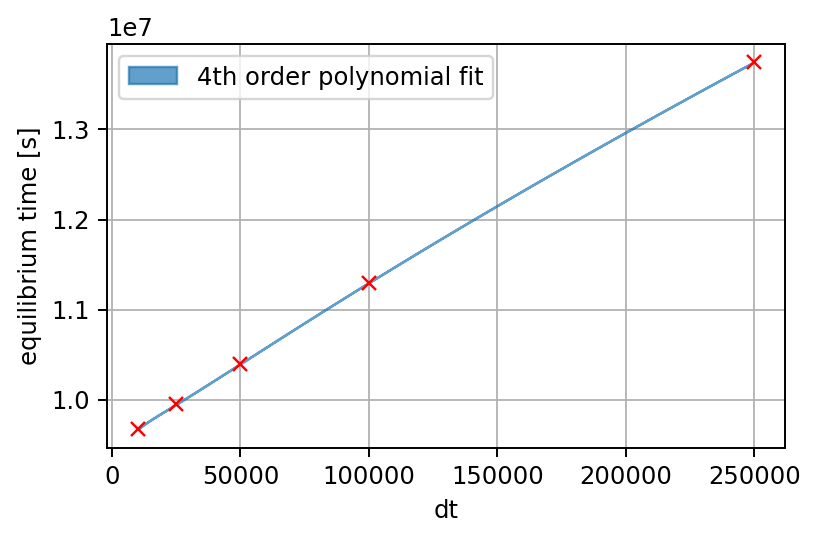

In [112]:
dts = [10000,25000,50000,100000,250000]
files = [f"dt{dt}.csv" for dt in dts]
names = [f"dt = {dt}" for dt in dts]

# Define your model function
def model(x, a, b):
    return a * x**b

x=[]
y=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    x.append(sim_data["dt"][0])
    y.append(sim_data["final_time"][0])
x=np.array(x)
y=np.array(y)
y = y
plt.plot(x, y, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(x), max(x), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(y) - poly(np.log10(x))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [s]")
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("dt")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.9)
plt.grid(which="minor", alpha=0.5)

ValueError: array must not contain infs or NaNs

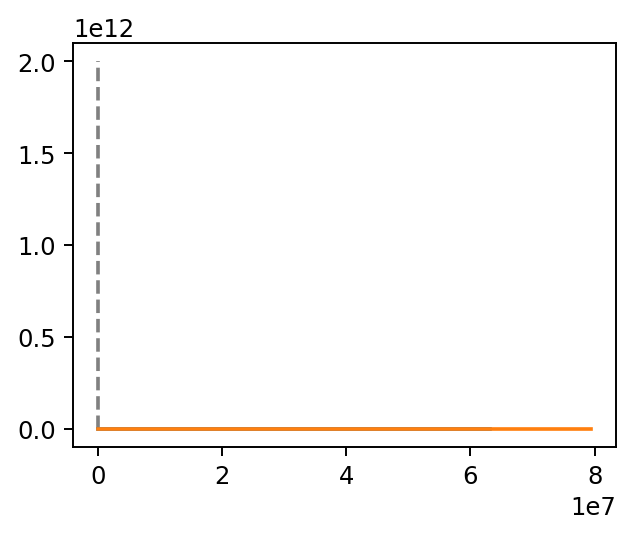

In [101]:
# Example usage with optional fontsize
spds = [5,10,20,40,80,120]
files = [f"samples_pd{spd}.csv" for spd in spds]
names = [f"samples per dec{spd}" for spd in spds]
plot_with_fit(files, names, fontsize=12, x_range=[1e1, 1e8])

# LOG STEP

Text(0.5, 0, 'Lorentz factor')

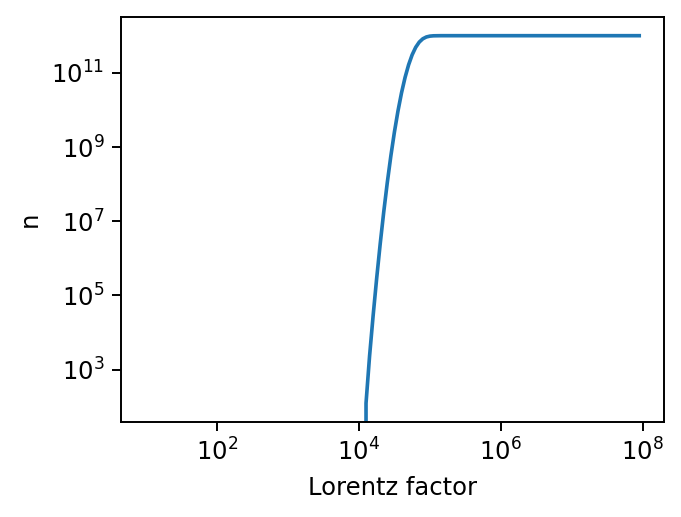

In [143]:
sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\log_step_simulation_data.csv",
header=None,
low_memory=False,
)
plt.figure(figsize=[4,3])
sim_data=sim_data.T
sim_data.columns = sim_data.iloc[0]
sim_data = sim_data[1:]
sim_data.reset_index(drop=True, inplace=True)
plt.plot(sim_data["gamma"], sim_data.iloc[:,-1])
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-28)
#plt.xlim(1e1, 1e5)
plt.xlabel("Lorentz factor")

# STEADY STATE

Text(0.5, 0, 'Lorentz factor')

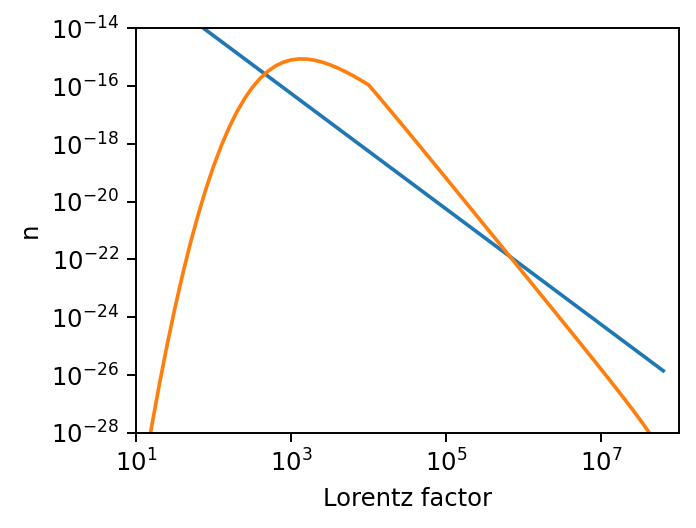

In [126]:
# Set display options for precision
pd.set_option('display.float_format', '{:.10e}'.format)

# Example code
plt.figure(figsize=[4, 3])
sim_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\B1000.csv")

#print(sim_data.to_string())
plt.plot(sim_data["gamma"], sim_data["0"])
plt.plot(sim_data["gamma"], sim_data.iloc[:,2])
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-28, 1e-14)
plt.xlim(1e1, 1e8)
plt.xlabel("Lorentz factor")

B = 0.1
B = 0.25
B = 0.5
B = 1.0
B = 1.5
B = 2.0


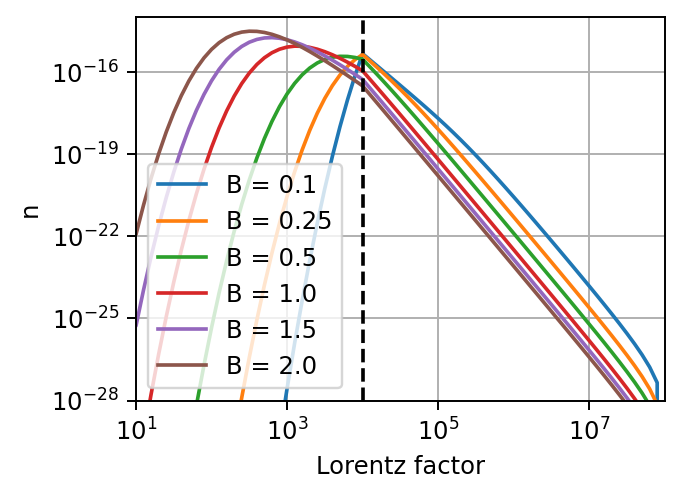

In [156]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    plt.plot(sim_data["gamma"], sim_data.iloc[:,2], label=name)
    print(name)
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Lorentz factor")
plt.xlim(1e1,1e8)
plt.ylim(1e-28,1e-14)
plt.vlines(1e4, 1e-28, 1e-7, "black", "dashed")
plt.legend()
plt.tight_layout()
plt.grid()

B = 0.1
B = 0.25
B = 0.5
B = 1.0
B = 1.5
B = 2.0


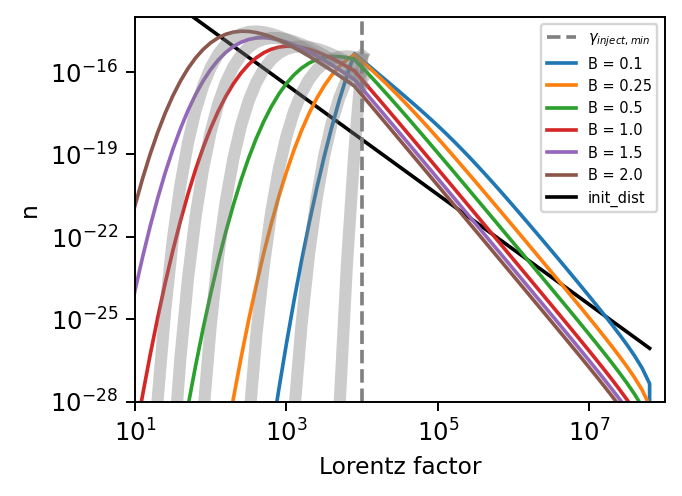

In [116]:
# Example usage with optional fontsize
files = ["B 100.csv", "B 250.csv", "B 500.csv", 
         "B1000.csv", "B1500.csv", "B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plot_with_fit(files, names, fontsize=12, plot_initial=True,x_range=[1e1, 1e8], 
              folder="csv_data\steady_state", lnn_bool=False)

# PHOTON POPULATION

In [1]:
# Example code

sim_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\simulation_data.csv")

fig, ax = plt.subplots(2, 1, figsize = (4, 6))

# plot the electron population
ax[0].loglog(eV_e(sim_data["gamma"][1:-1]), sim_data["iter final"][1:-1])
ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e6, 1e12)
ax[0].set_ylim(1e-32, 1e-12)    

# plot the resulting photon population
ax[1].loglog(eV_p(sim_data["photon_freq"][1:-1]), sim_data["photon_n"][1:-1])
ax[1].set_xlabel(r"comoving photon energy (eV)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
ax[1].set_xlim(1e-6, 1e4)
ax[1].set_ylim(1e-4, 2e0)
plt.tight_layout()

# show
plt.draw()
plt.show()

NameError: name 'pd' is not defined

KeyError: 'iter 1'

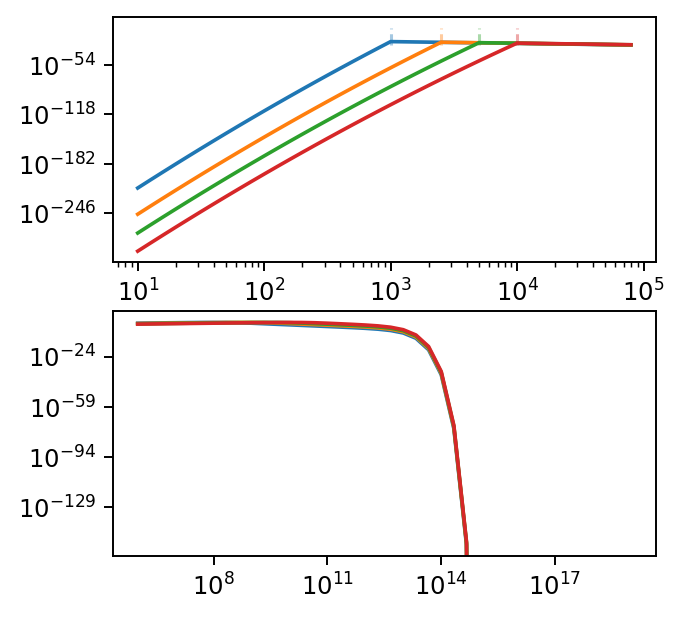

In [290]:
colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", 
            "tab:brown", "tab:pink","tab:grey", "tab:olive", "tab:cyan"]

mins = [1000,2500,5000,10000,25000,50000]
files = [f"inject_min{minimum}.csv" for minimum in mins]
names = [f"{minimum}" for minimum in mins]

fig, ax = plt.subplots(2, 1, figsize = (4, 4))
for file, name, colour in zip(files,names, colours): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    # plot the electron population
    ax[0].loglog(sim_data["gamma"][1:-1], sim_data["iter 1"][1:-1], label=name, c=colour)
    ax[0].vlines(run_data["inject_min"][0], 1e-28, 1e-7, colour, "dashed", lw=1.25, alpha=0.4)
    
    # plot the resulting photon population
    ax[1].loglog(sim_data["photon_freq"][1:-1], sim_data["photon_n"][1:-1], label=name, c=colour)

ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e0, 2e9)
ax[0].set_ylim(1e-28, 1e-13)
ax[0].legend(title="$\gamma_{inject}$",loc="upper right", frameon=False, fontsize=6, title_fontsize=6)

ax[1].set_xlabel(r"co-moving frequency $\nu$ (Hz)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
#ax[1].set_xlim(1e5,1e23)
ax[1].set_ylim(1e-12, 10)

plt.tight_layout()
plt.show()

peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(sim_data["photon_freq"].loc[sim_data["photon_n"] == 1].values[0])
    B.append(run_data["inject_min"][0])

plt.plot(B, peak_freq, "rx")

x=B
y=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(x, y)
plt.xlabel("inject min")
#plt.yscale("log")
#plt.xscale("log")
plt.ylabel("peak frequency")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

        4       3         2
-2.041 x - 1.7 x - 1.403 x - 2.727 x + 12.27


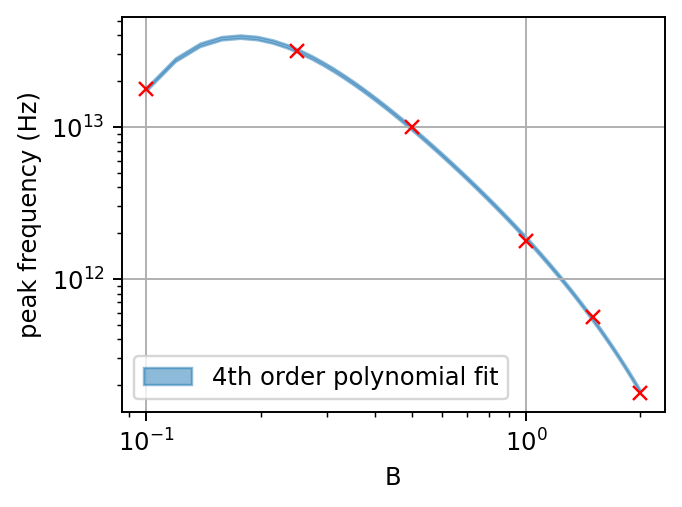

In [236]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(sim_data["photon_freq"].loc[sim_data["photon_n"] == 1].values[0])
    B.append(run_data["B"][0])

plt.plot(B, peak_freq, "rx")

x=B
y=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(x, y)
plt.xlabel("B")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("peak frequency (Hz)")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

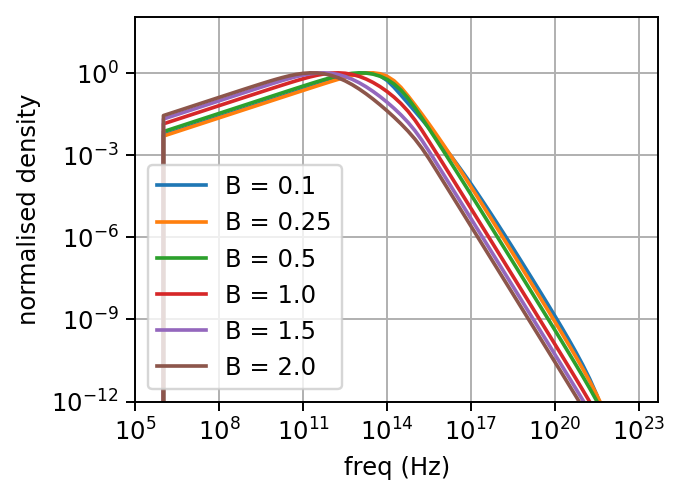

In [235]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    plt.plot(sim_data["photon_freq"], sim_data["photon_n"], label = name)
plt.ylabel("normalised density")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("freq (Hz)")
plt.xlim(1e5, 5e23)
plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

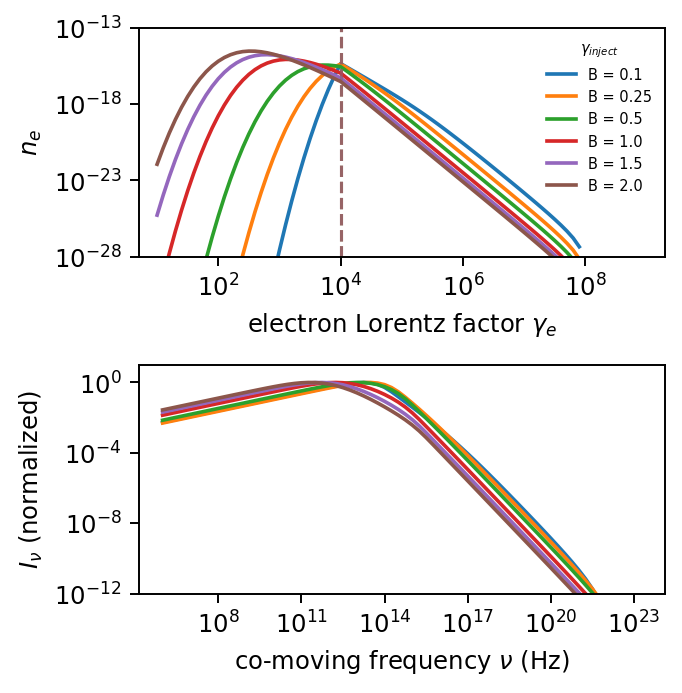

        4       3         2
-2.041 x - 1.7 x - 1.403 x - 2.727 x + 12.27


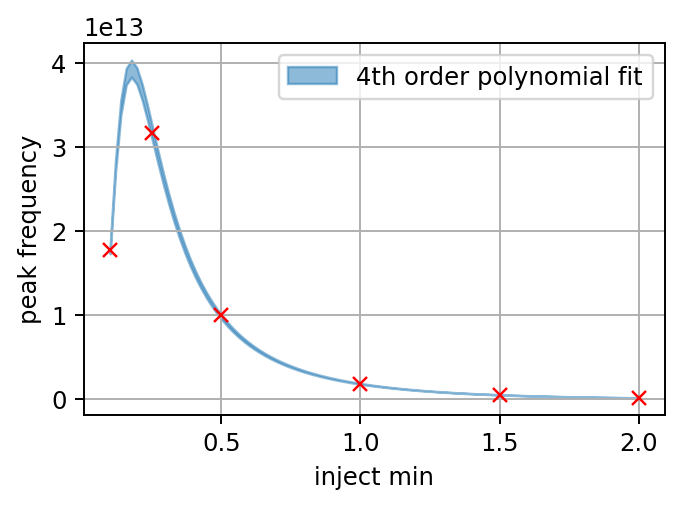

In [242]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]

fig, ax = plt.subplots(2, 1, figsize = (4, 4))
for file, name, colour in zip(files,names, colours): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    # plot the electron population
    ax[0].loglog(sim_data["gamma"][1:-1], sim_data["iter 1"][1:-1], label=name, c=colour)
    ax[0].vlines(run_data["inject_min"][0], 1e-28, 1e-7, colour, "dashed", lw=1.25, alpha=0.4)
    
    # plot the resulting photon population
    ax[1].loglog(sim_data["photon_freq"][1:-1], sim_data["photon_n"][1:-1], label=name, c=colour)

ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e0, 2e9)
ax[0].set_ylim(1e-28, 1e-13)
ax[0].legend(title="$\gamma_{inject}$",loc="upper right", frameon=False, fontsize=6, title_fontsize=6)

ax[1].set_xlabel(r"co-moving frequency $\nu$ (Hz)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
#ax[1].set_xlim(1e5,1e23)
ax[1].set_ylim(1e-12, 10)

plt.tight_layout()
plt.show()

peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    sim_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(sim_data["photon_freq"].loc[sim_data["photon_n"] == 1].values[0])
    B.append(run_data["B"][0])

plt.plot(B, peak_freq, "rx")

x=B
y=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(x, y)
plt.xlabel("inject min")
#plt.yscale("log")
#plt.xscale("log")
plt.ylabel("peak frequency")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()